[iris 데이터셋을 활용한 꽃잎 너비 예측]
- 데이터셋: iris.csv에서 2개의 feature 사용
- 구현 프레임워크: Pytorch

[1] 모듈 로딩 및 데이터 준비

In [1]:
#모듈 로딩
import torch                                    #텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                           #인공신경망 관련 모듈
import torch.nn.functional as F                 #손실함수, 거래함수 등 관련 모듈
import torch.optim as optimizer                 #최적화 기법 관련 모듈
from torchmetrics.regression import R2Score     #성능지표 관련 모듈
from torchinfo import summary                   #모델 정보 관련 모듈

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
#모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

#저장 및 실행 위치 설정
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cpu


In [4]:
#데이터 로딩:  csv -> DataFrame
data_file='../data/iris.csv'
irisDF=pd.read_csv(data_file,usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습 방법: 지도학습 중 회귀
- 알고리즘: 선형모델 (nn.Linear)

In [5]:
#모델 설계
#입력층 입력값: sepal.length, sepal.width, petal.length 1개
#출력층 출력값: petal.width 1개

#이전 층의 출력 = 다음 층의 입력

# 입력층: 입력 피쳐 3개, 출력 입력층에 존재하는 퍼셉트론 개수 10개, AF ReLU
# 은닉층: 입력 10개, 출력 은닉층에 존재하는 퍼셉트론 개수 5개, AF ReLU
# 출력층: 입력 5개, 출력 타겟(라벨) 개수 1개, AF None

model=nn.Sequential(nn.Linear(3,10),
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1))

In [6]:
#모델 구조 확인
print(model)
summary(model,input_size=(3,))      # param = (feature 개수+절편) * 퍼셉트론 개수

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [7]:
#가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param} \n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True) 

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True) 

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038, 

[3] 최적화 인스턴스 준비

In [8]:
#모델의 가중치와 절편 최적화 -> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습: 개발자가 구현
1) DS Tensor화
- 데이터 준비 시 진행하거나 학습 전 진행
    - 하고싶을 때 하면 된다~~~~~~~

In [9]:
feature_df=irisDF[irisDF.columns[:-1]]
target_df=irisDF[['petal.width']]

print(feature_df.shape,target_df.shape)

(150, 3) (150, 1)


In [10]:
x_train,x_test,y_train,y_test=train_test_split(feature_df, target_df,test_size=0.2,random_state=10)

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=10)

print(f'[FEATURE] TRAIN {x_train.shape}, TEST {x_test.shape}, VALIDATE {x_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VALIDATE {y_val.shape}')

[FEATURE] TRAIN (96, 3), TEST (30, 3), VALIDATE (24, 3)
[TARGET] TRAIN (96, 1), TEST (30, 1), VALIDATE (24, 1)


2) 학습 진행
- 학습 횟수 결정: 에포크 설정
- 배치 크기 결정
- 배치 개수 계산

In [11]:
EPOCH=100                                   #총 학습량???
BATCH_SIZE=12                               #한 번 학습할 분량
BATCH_CNT=x_train.shape[0]//BATCH_SIZE      #총 학습 횟수(업데이트 횟수)

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 100, BATCH_SIZE: 12, BATCH_CNT: 8


In [12]:
#테스트/검증 함수: 최적화(가중치, 절편 업데이트) 진행 X

def testing(testDF,targetDF,kind='val'):        
    
    #tensor화
    testTS=torch.FloatTensor(testDF.values).to(device)
    test_targetTS=torch.FloatTensor(targetDF.values).to(device)

    with torch.no_grad():       #가중치, 절편 업데이트 진행 X
        #학습 진행 - forward
        pre_y=model(testTS)

        #오차 계산 - 손실함수
        loss=F.mse_loss(pre_y,test_targetTS)

        #성능평가-r2score
        r2=R2Score()(pre_y,test_targetTS)

        #학습 결과 출력 및 저장
        # print(f'[{kind}] LOSS: {loss}, R2: {r2}')

    return loss.item(),r2

In [13]:
#모델 학습 함수

def training(featureTS,targetTS,valTS,val_TargetTS): 

    loss_history=[[],[]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):
        #배치 손실 저장 변수
        bs_loss=0
        bs_r2=0

        #배치 크기만큼 학습 진행
        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end=start+BATCH_SIZE
            # print(start,end)

            #배치 사이즈 크기만큼 데이터 추출해서 tensor화 진행
            bsx_train=torch.FloatTensor(x_train[start:end].values).to(device)
            bsy_train=torch.FloatTensor(y_train[start:end].values).to(device)

            # print(bsx_train.shape,bsx_train.device,bsx_train.dtype)
            # print(bsy_train.shape,bsy_train.device,bsy_train.dtype)

            #학습 진행 - forward
            pre_y=model(bsx_train)
            # print(f'pre_y.shape: {pre_y.shape}')

            #오차 계산 - 손실함수
            loss=F.mse_loss(pre_y,bsy_train)
            bs_loss+=loss.item()
            bs_r2+=R2Score()(pre_y,bsy_train).item()

            #최적화 -  가중치, 절편 업데이트(backward)
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        #검증
        val_loss,val_r2=testing(valTS,val_TargetTS)
        loss_history[1].append(val_loss)
        r2_history[1].append(val_r2)

        #에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        #학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n TRAIN LOSS: {loss_history[0][-1]}, R2: {r2_history[0][-1]}')
        print(f'VAL LOSS: {loss_history[1][-1]}, R2: {r2_history[1][-1]}')

    return loss_history,r2_history

In [14]:
#모델 학습 진행
loss,r2=training(x_train,y_train,x_val,y_val)

[0/100]
 TRAIN LOSS: 0.6837206520140171, R2: -0.553242027759552
VAL LOSS: 0.4822777807712555, R2: 0.20275545120239258
[1/100]
 TRAIN LOSS: 0.37688421458005905, R2: 0.23998700827360153
VAL LOSS: 0.25975126028060913, R2: 0.5706099271774292
[2/100]
 TRAIN LOSS: 0.16829693876206875, R2: 0.6632067114114761
VAL LOSS: 0.1180422380566597, R2: 0.8048665523529053
[3/100]
 TRAIN LOSS: 0.0913331308402121, R2: 0.8207240998744965
VAL LOSS: 0.08625302463769913, R2: 0.8574166893959045
[4/100]
 TRAIN LOSS: 0.08960783900693059, R2: 0.825396753847599
VAL LOSS: 0.08871450275182724, R2: 0.853347659111023
[5/100]
 TRAIN LOSS: 0.0820746049284935, R2: 0.8367414548993111
VAL LOSS: 0.09023738652467728, R2: 0.8508301973342896
[6/100]
 TRAIN LOSS: 0.07489298656582832, R2: 0.8469331562519073
VAL LOSS: 0.09456110745668411, R2: 0.8436827659606934
[7/100]
 TRAIN LOSS: 0.07485788408666849, R2: 0.844779759645462
VAL LOSS: 0.09353557974100113, R2: 0.845378041267395
[8/100]
 TRAIN LOSS: 0.0764003754593432, R2: 0.84130987

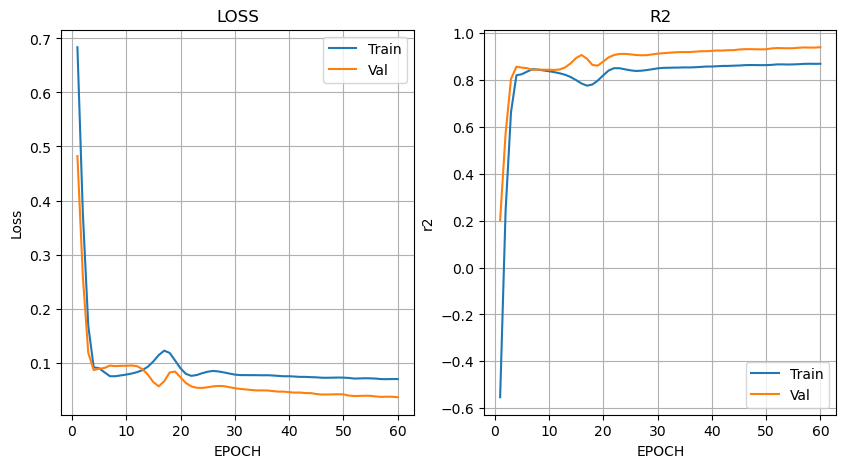

In [19]:
#학습 후 loss 시각화
import matplotlib.pyplot as plt

threshold=60
fig,axes=plt.subplots(1,2,figsize=(10,5))


axes[0].plot(range(1,threshold+1),loss[0][:threshold],label='Train')
axes[0].plot(range(1,threshold+1),loss[1][:threshold],label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,threshold+1),r2[0][:threshold],label='Train')
axes[1].plot(range(1,threshold+1),r2[1][:threshold],label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('r2')
axes[1].set_title('R2')

plt.show()